In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

import pandas as pd
from sklearn.cluster import KMeans
import dofitPython_functions as LogFit 

In [2]:

Peter_ds = xr.open_dataset("/share/pech2273/SMRECEARTHPeterVariables.nc")
PeterIFS_ds = xr.open_dataset("/share/pech2273/SMRECEARTHPeterVariablesIFS.nc")
#SMRlevsECslice = Peter_ds.sel(station = 'SMR-II').isel(time = slice(1,1000))


In [3]:
x = xr.DataArray(np.logspace(-1.5,6, num=100), dims =['D'], coords= {'D':np.logspace(-1.5,6, num=100)})
diam_variables=['RDRY_NUS','RDRY_AIS','RDRY_ACS','RWET_AII','RDRY_COS','RWET_ACI','RWET_COI',]
diam_Sigma = [1.59,1.59,1.59,2,1.59,1.59,2]
Pdf =['PDF_NUS','PDF_AIS','PDF_ACS','PDF_AII','PDF_COS','PDF_ACI','PDF_COI',]

In [4]:
# Function that creates the probability density functions for the 7 modes
    # Units for X axis are nanometers
def ECEarthpdf (Data, Xspace=x):
    for d in diam_variables:
        Data[d] = Data[d].where(Data[d]>0)
        if Data[d].units=='m':
            Data[d]=Data[d]*1e9
            Data[d].attrs['units']='nm'
            print('changing to nm')
    for i in range(0,len(diam_variables)):
        Data[f'{Pdf[i]}'] = np.exp(-(np.log10(x) - np.log10(2*Data[f'{diam_variables[i]}']))**2 / (2 * np.log10(diam_Sigma[i])**2))/ (( np.log10(diam_Sigma[i])* np.sqrt(2 * np.pi)))
    return



In [5]:
ECEarthpdf(Peter_ds)

changing to nm
changing to nm
changing to nm
changing to nm
changing to nm
changing to nm
changing to nm


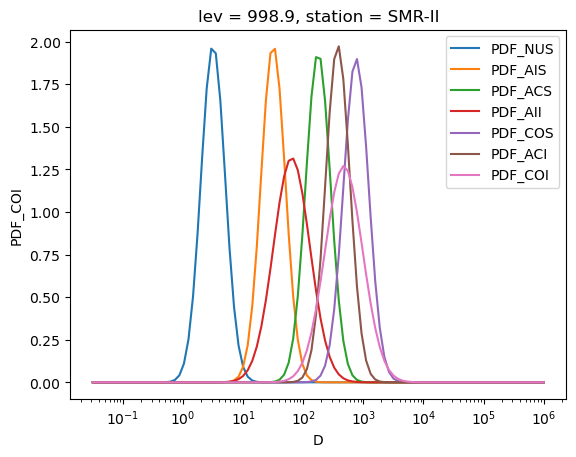

In [6]:
for p in Pdf:
    Peter_ds[p].isel(lev = 0).mean('time').plot(xscale='log', label=p)
plt.legend()


In [7]:
dis_variable = ['NUS_dis','AIS_dis','ACS_dis','COS_dis','AII_dis','ACI_dis','COI_dis']
Numb_variables = ['N_NUS','N_AIS','N_ACS','N_AII','N_COS','N_ACI','N_COI',]
def ECearthDistribution (Data, Xspace = x):
    for i in range(0, len(dis_variable)):
        Data[dis_variable[i]] = Data[Pdf[i]]*Data[Numb_variables[i]]
    Data['Tot_dis'] = Data['NUS_dis']+Data['AIS_dis']+Data['ACS_dis']+Data['COS_dis']+Data['AII_dis']+Data['ACI_dis']+Data['COI_dis']
    return
    

In [8]:
ECearthDistribution(Peter_ds)


Text(0.5, 0, 'D (nm)')

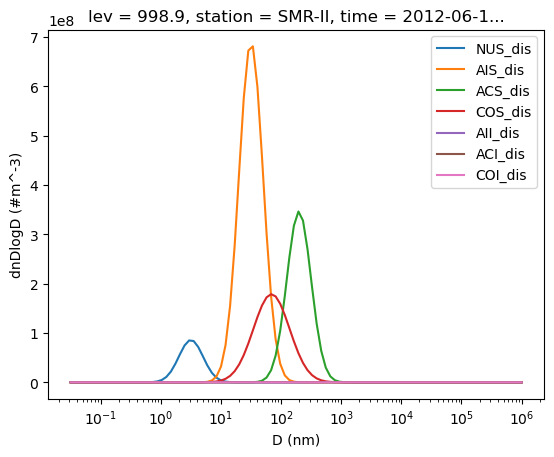

In [9]:

for d in dis_variable:
    Peter_ds[d].isel(time = 4000, lev = 0).plot(xscale='log', label=d)
plt.legend()
plt.ylabel('dnDlogD (#m^-3)')
plt.xlabel('D (nm)')


In [10]:
print(np.float64(Peter_ds['N_NUS'].isel(time = 4000, lev = 0)))
print(np.float64(Peter_ds['RDRY_NUS'].isel(time = 4000, lev = 0)))



43321528.0
1.5811387300491333


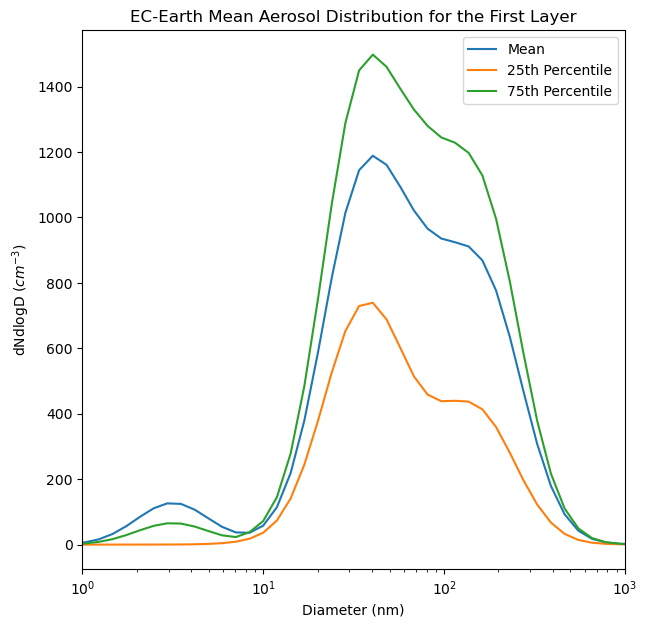

In [11]:
plt.figure(figsize =(7,7))

(Peter_ds['Tot_dis']*1E-6).isel(lev = 0).mean('time').plot(xscale = 'log', xlim = [1,1000], label = 'Mean')

(Peter_ds['Tot_dis']*1E-6).isel(lev = 0).quantile(0.25, dim='time').plot(label = '25th Percentile')
(Peter_ds['Tot_dis']*1E-6).isel(lev = 0).quantile(0.75, dim='time').plot(label = '75th Percentile')
plt.xlabel('Diameter (nm)')
plt.ylabel('dNdlogD ($cm^{-3}$)')
plt.title('EC-Earth Mean Aerosol Distribution for the First Layer')
plt.legend()



In [12]:
Peter_ds['N_AIS']

<xarray.DataArray 'N_AIS' (time: 61369, lev: 34)> Size: 8MB
[2086546 values with dtype=float32]
Coordinates:
  * lev        (lev) float32 136B 998.9 987.3 964.2 ... 1.405 0.4877 0.1071
    station    <U6 24B ...
  * time       (time) datetime64[ns] 491kB 2012-01-01 ... 2019-01-01
    time_orig  (time) datetime64[ns] 491kB ...
Attributes:
    long_name:     number concentration of AIS_N
    units:         1 m-3
    cell_methods:  time: mean

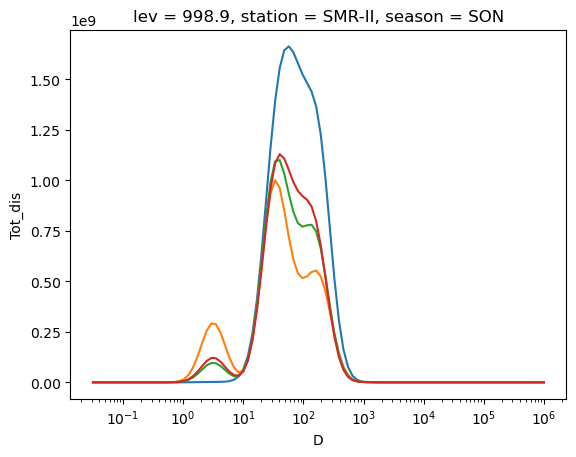

In [13]:
Ds_ = Peter_ds['Tot_dis'].isel(lev = 0).groupby(Peter_ds['time.season']).mean()
Ds_.isel(season = 0).plot(xscale = 'log')
Ds_.isel(season = 1).plot(xscale = 'log')
Ds_.isel(season = 2).plot(xscale = 'log')
Ds_.isel(season = 3).plot(xscale = 'log')


In [14]:
dx = xr.DataArray(np.logspace(-1.5,6, num=100), dims =['Dx'], coords= {'Dx':np.logspace(-1.5,6, num=100)})
for i in range (1,len(dx)):
    dx[i]= np.log(x[i]/x[i-1])
dx[0]=dx[1]
def n70ECearth(Data, DeltaX = dx):
    Data['TotalN70'] = Data['Tot_dis'].where(Data['D']>70).sum('D')*DeltaX[1]
    return
n70ECearth(Peter_ds)


In [15]:

season = Peter_ds.groupby(Peter_ds['time.season'])

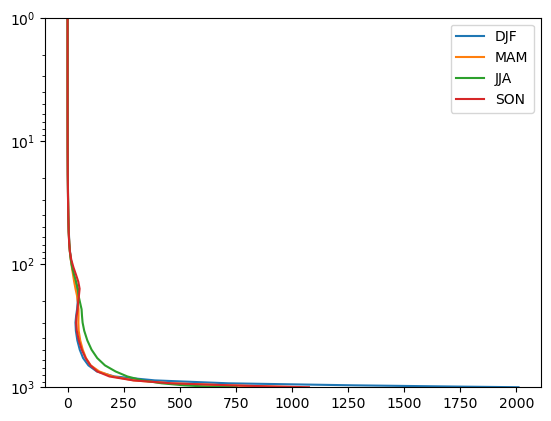

In [16]:
for a in ['DJF','MAM','JJA','SON']:
    plt.plot(season[a]['TotalN70'].mean('time')/10**6, season[a]['lev'], label = a )
plt.yscale('log')
plt.ylim([1000,1])
plt.legend()

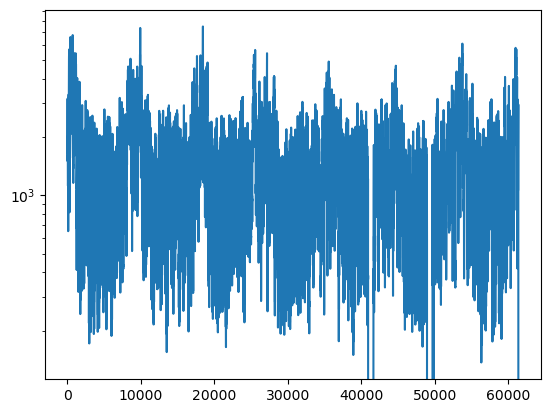

In [17]:
plt.plot(Peter_ds['TotalN70'].isel(lev = 0)/10**6)
plt.yscale('log')

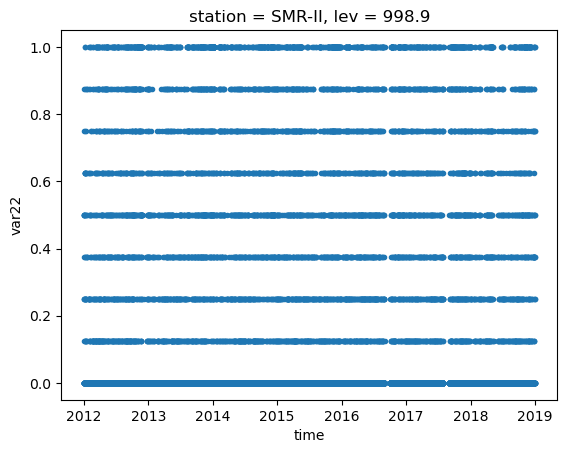

In [18]:
(PeterIFS_ds['var22'].isel(lev=0)/60/60/3).plot(marker='.')

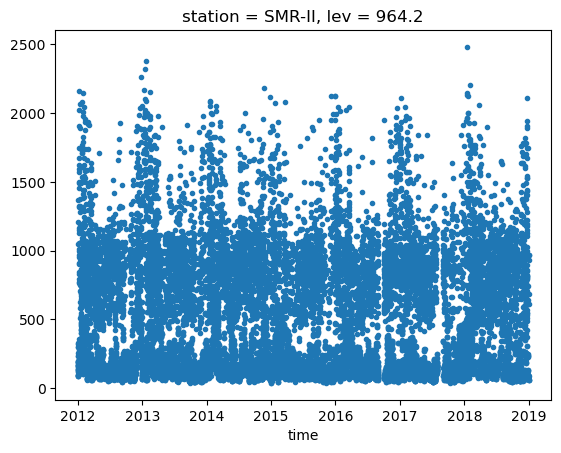

In [19]:
(PeterIFS_ds['var20'].isel(lev=2)/(PeterIFS_ds['var22'].isel(lev=2))).plot(marker='.')

In [20]:
PeterIFS_ds['Droplets'] = (PeterIFS_ds['var20']/PeterIFS_ds['var22']).where(PeterIFS_ds['var22']>=0)
Peter_ds['Droplets'] = (PeterIFS_ds['var20']/PeterIFS_ds['var22']).where(PeterIFS_ds['var22']>=0)

(array([1.0506e+04, 2.0300e+03, 2.1850e+03, 3.0290e+03, 1.2660e+03,
        4.3800e+02, 2.8800e+02, 1.6600e+02, 4.7000e+01, 4.0000e+00]),
 array([  37.92592621,  282.33331299,  526.74072266,  771.14807129,
        1015.55548096, 1259.96289062, 1504.37023926, 1748.77770996,
        1993.18505859, 2237.5925293 , 2482.        ]),
 <BarContainer object of 10 artists>)

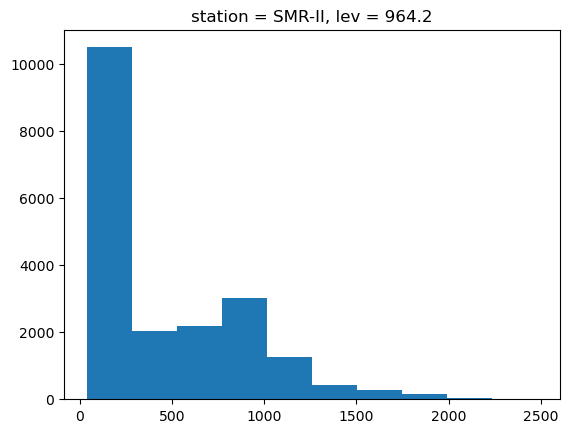

In [21]:
(PeterIFS_ds['var20'].isel(lev=2)/(PeterIFS_ds['var22'].isel(lev=2))).plot.hist()

In [22]:
def seasonalgraph(Dataset, DatasetIFS,Season, maxlevel, maxseasonnumber):
    #plt.figure(figsize=(8,3))   
    for i in range(0,maxlevel-1):
        
        x = Dataset[Season]['TotalN70'].isel(lev = i).where(DatasetIFS[Season]['var20'].isel(lev =i)>0).dropna('time')/10**6
        y = Dataset[Season]['Droplets'].isel(lev = i).where(DatasetIFS[Season]['var20'].isel(lev =i)>0).dropna('time')
        x  =x.to_numpy()
        y = y.to_numpy()
        res = stats.linregress(np.log10(x),np.log10(y))
        Y = np.log10(y)
        X = np.log10(x)
        X = sm.add_constant(X)
        model = sm.OLS(Y,X).fit()
        print(f'{Season}')
        print('Level ' f'{i}')
        print(model.summary())
        if Season == 'DJF':
            fig = NdtoCCNGraphseason(1,i,maxlevel,x,y,res, maxseasonnumber)
        if Season == 'MAM':
            fig = NdtoCCNGraphseason(2,i,maxlevel,x,y,res, maxseasonnumber)
        if Season == 'JJA':
            fig = NdtoCCNGraphseason(3,i,maxlevel,x,y,res, maxseasonnumber)
        if Season == 'SON':
            fig = NdtoCCNGraphseason(4,i,maxlevel,x,y,res, maxseasonnumber)
    return fig

def NdtoCCNGraphseason(seasonnumber,level, maxlevel, x,y,res,maxseasonnumber):
    lims = [1,10000]
    fig = plt.subplot(maxseasonnumber,maxlevel-1,level+1+(seasonnumber-1)*(maxlevel-1))
    plt.hexbin(x,y,gridsize=50, bins= 'log', xscale='log', yscale='log',edgecolors = 'face', cmap ='inferno',extent = [0,4,0,4], mincnt = 1)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot([1,10000],[10**res.intercept*1**res.slope,10**res.intercept*10000**res.slope])
    plt.plot(lims,lims)
    plt.colorbar(label='counts')
    plt.xlabel('CCN')
    plt.ylabel('Nd')
    
    return fig
def NdtoCCNGraph(x,y):
    x = x.to_numpy()
    y = y.to_numpy()
    Y = np.log10(y)
    X = np.log10(x)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    res = stats.linregress(np.log10(x),np.log10(y))
    lims = [1,10000]
    fig = plt.hexbin(x,y,gridsize=50, bins= 'log', xscale='log', yscale='log',edgecolors = 'face', cmap ='inferno',extent = [0,4,0,4], mincnt = 1)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot([1,10000],[10**res.intercept*1**res.slope,10**res.intercept*10000**res.slope])
    plt.plot(lims,lims)
   # plt.colorbar(label='counts')
    plt.xlabel('CCN, $cm^{-3}$')
    plt.ylabel('Nd, $cm^{-3}$')
    print(model.summary())
    return fig

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     7711.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:00:31   Log-Likelihood:                 2900.5
No. Observations:                7095   AIC:                            -5797.
Df Residuals:                    7093   BIC:                            -5783.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4876      0.021     23.745      0.0

Text(0.5, 1.0, 'Level 0')

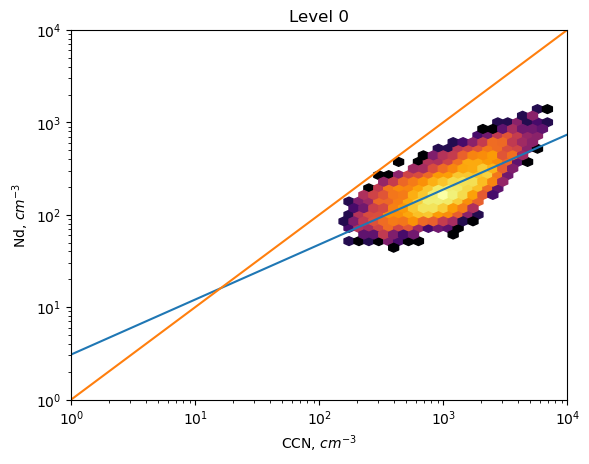

In [23]:

x = Peter_ds['TotalN70'].isel(lev = 0).where(PeterIFS_ds['Droplets'].isel(lev = 0)>0).dropna('time')/10**6
y = PeterIFS_ds['Droplets'].isel(lev = 0).where(PeterIFS_ds['Droplets'].isel(lev = 0)>0).dropna('time')
NdtoCCNGraph(x,y)

plt.title('Level 0')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     7711.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:00:32   Log-Likelihood:                 2900.5
No. Observations:                7095   AIC:                            -5797.
Df Residuals:                    7093   BIC:                            -5783.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4876      0.021     23.745      0.0

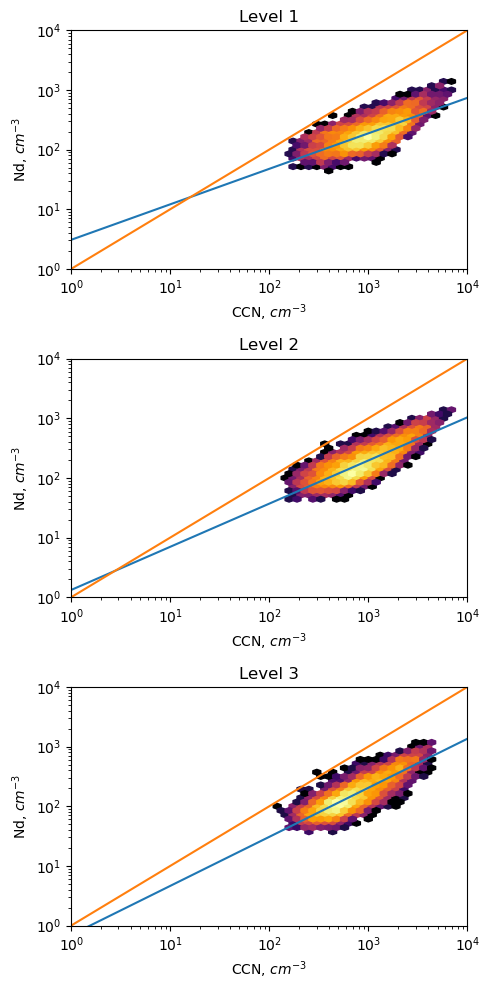

In [24]:
x = Peter_ds['TotalN70'].isel(lev = 0).where(PeterIFS_ds['Droplets'].isel(lev = 0)>0).dropna('time')/10**6
y = Peter_ds['Droplets'].isel(lev = 0).where(PeterIFS_ds['Droplets'].isel(lev = 0)>0).dropna('time')
plt.figure(figsize = (5,10))
plt.subplot(3,1,1)
NdtoCCNGraph(x,y)
plt.title('Level 1')

x = Peter_ds['TotalN70'].isel(lev = 1).where(PeterIFS_ds['var20'].isel(lev = 1)>0).dropna('time')/10**6
y = Peter_ds['Droplets'].isel(lev = 1).where(PeterIFS_ds['var20'].isel(lev = 1)>0).dropna('time')
plt.subplot(3,1,2)
NdtoCCNGraph(x,y)
plt.title('Level 2')

x = Peter_ds['TotalN70'].isel(lev = 2).where(PeterIFS_ds['var20'].isel(lev = 2)>0).dropna('time')/10**6
y = Peter_ds['Droplets'].isel(lev = 2).where(PeterIFS_ds['var20'].isel(lev = 2)>0).dropna('time')
plt.subplot(3,1,3)
NdtoCCNGraph(x,y)
plt.title('Level 3')
plt.tight_layout()

In [25]:
ds_seasons = Peter_ds.groupby(Peter_ds['time.season'])
ds_IFSseasons = PeterIFS_ds.groupby(PeterIFS_ds['time.season'])


DJF
Level 0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     3715.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:00:41   Log-Likelihood:                 942.34
No. Observations:                1660   AIC:                            -1881.
Df Residuals:                    1658   BIC:                            -1870.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2572      0.043     -5.

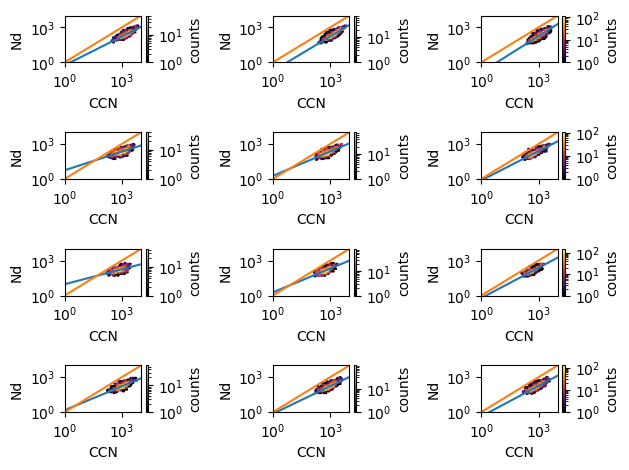

In [26]:
season = ['DJF', 'MAM','JJA','SON']
for seas in season: 
    seasonalgraph(ds_seasons,ds_IFSseasons,seas,4,4)
    plt.tight_layout()

DJF
Level 0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     3715.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:02:21   Log-Likelihood:                 942.34
No. Observations:                1660   AIC:                            -1881.
Df Residuals:                    1658   BIC:                            -1870.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2572      0.043     -5.

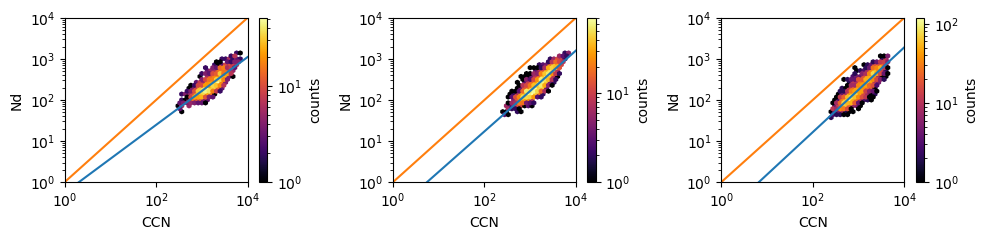

In [27]:
season = ['DJF']
plt.figure(figsize = (10,2.5))
for seas in season: 
    seasonalgraph(ds_seasons,ds_IFSseasons,seas,4,len(season))
    plt.tight_layout()

In [28]:
#(n_samples, n_features)
sizedist4clust =Peter_ds['Tot_dis'].isel(lev=0).T

In [29]:
sizedist4clust=sizedist4clust.dropna(dim='time')

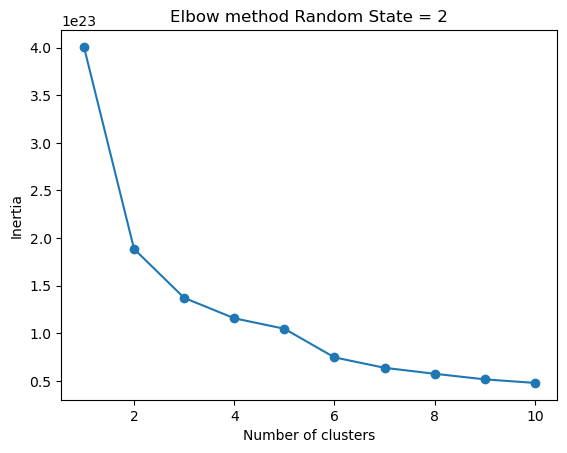

In [30]:
n = 2
inertias = [] 
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=n)
    kmeans.fit(sizedist4clust)
    inertias.append(kmeans.inertia_)
plt.plot(range(1,11), inertias, marker='o')
plt.title(f'Elbow method Random State = {n}')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



In [31]:
kmeans = KMeans(n_clusters=6, random_state = 2)
kmeans.fit(sizedist4clust)

myds = sizedist4clust.to_dataset()
myds['label'] = xr.DataArray(kmeans.labels_, dims=('time',))
myds

<xarray.Dataset> Size: 49MB
Dimensions:    (time: 59903, D: 100)
Coordinates:
    lev        float32 4B 998.9
    station    <U6 24B ...
  * time       (time) datetime64[ns] 479kB 2012-01-01 ... 2018-12-31T23:00:00
    time_orig  (time) datetime64[ns] 479kB ...
  * D          (D) float64 800B 0.03162 0.03765 0.04482 ... 8.399e+05 1e+06
    Dx         float64 8B 0.03765
Data variables:
    Tot_dis    (time, D) float64 48MB 1.291e-16 4.554e-15 ... 4.526e-26
    label      (time) int32 240kB 3 3 3 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 3 3 3 3 3

In [32]:
TempREindex = PeterIFS_ds['var130'].isel(lev = 0).reindex(time=myds['time']).ffill('time')

In [33]:
TempMeans = TempREindex.groupby(myds.label).mean()
TempMeans

<xarray.DataArray 'var130' (label: 6)> Size: 24B
array([263.23233, 278.20587, 280.09122, 274.5749 , 268.19568, 285.37796],
      dtype=float32)
Coordinates:
    station  <U6 24B ...
    lev      float32 4B 998.9
  * label    (label) int32 24B 0 1 2 3 4 5
Attributes:
    table:             128
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  128

In [34]:
myds_med = myds['Tot_dis'].groupby(myds['label']).median()

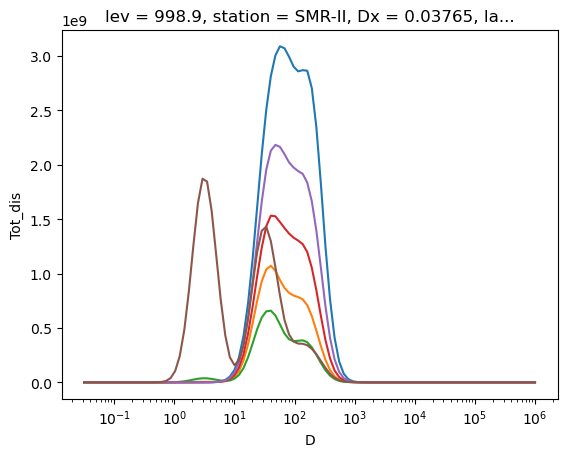

In [35]:
for l in myds_med.label:
    myds_med.sel(label=l).plot()
    plt.xscale('log')


In [36]:
#Peter_ds.to_netcdf('/share/pech2273/ECEarthDist.nc')


In [37]:
df = pd.DataFrame(Peter_ds['Tot_dis'].isel(lev = 0).mean('time'))
Dp = pd.DataFrame(Peter_ds['D'])

In [38]:
Dp_ = Dp*1e-9
distrib = df.values

In [39]:
estimate = LogFit.fit_3_modes(Peter_ds['D']*1e-9,Peter_ds['Tot_dis'].isel(lev = 0).mean('time'), 'yes')

In [40]:
estimate

[[np.float64(3.336201074400112e-08),
  np.float64(7.560418172246163e-08),
  np.float64(1.8301979002187406e-07)],
 array([1.5, 1.5, 1.5]),
 array([[4.78338391e+08],
        [3.52096823e+08],
        [3.40353607e+08]])]

In [41]:
def log_distrib(Dpg,sig,Ntot,Dp):
    return Ntot * 0.39894228 / np.log10(sig) * np.exp(-0.5*(np.log10(Dp)-np.log10(Dpg))**2/(np.log10(sig)**2))

def style(ax):
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)
        ax.spines[axis].set_color('k')
    plt.rc('axes', linewidth=0.2)
    fontsize = 12
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    ax.tick_params(direction='out', length=8, width=1.3, pad=10, bottom=True, top=False, left=True, right=False, color='k')
    ax.tick_params(which='minor', length=4, color='k', width=1.3)
    
def plot_fit(Dp, distrib, estimate, ax):
    for i in range(len(estimate)):
        plt.plot(Dp,estimate[i], '--', label='fit mode ' + str(i), color='b')
    plt.plot(Dp,sum(estimate), label='fit', color='b', linewidth=3, alpha=0.6)
    plt.plot(Dp,distrib, color='r', label='measured', linewidth=3, alpha=0.6)
    ax.set_xscale('log')
    plt.legend()
    ax.grid(True, alpha=0.6)
    ax.set_xlabel(r'Dp ($nm$)', fontsize=15)
    style(ax)
    ax.set_ylabel(r'dN/dlogDg ($cm^{-3}$)', fontsize=15)
    ax.set_xlim([1,1000])
    ax.set_xticks([1,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])
    ax.set_xticklabels([1,10,'',30,'','','','','','',100,'','','', '', '', '', '', '', 1000])

In [42]:
df = pd.DataFrame(Peter_ds['Tot_dis'].isel(lev = 0).mean('time'))
Dp = pd.DataFrame(Peter_ds['D'])
estimate = []
for l in myds_med.label:
    estimate.append(LogFit.fit_3_modes(myds_med['D']*1E-9, myds_med.sel(label = l),'yes'))

In [43]:
estimate

[[[np.float64(3.336201074400112e-08),
   np.float64(7.560418172246147e-08),
   np.float64(2.0000000000000002e-07)],
  array([1.5, 1.5, 1.5]),
  array([[9.67913915e+08],
         [1.21145347e+09],
         [1.15614682e+09]])],
 [[np.float64(6.929669711460705e-08),
   np.float64(3.000353939985754e-08),
   np.float64(1.67481217698254e-07)],
  array([1.5, 1.5, 1.5]),
  array([[3.26379341e+08],
         [4.02499410e+08],
         [2.84819383e+08]])],
 [[np.float64(4.808198367019929e-08),
   np.float64(2.5720353614822956e-08),
   np.float64(1.5326188647871078e-07)],
  array([1.5, 1.5, 1.5]),
  array([[2.28594571e+08],
         [1.63677061e+08],
         [1.79041497e+08]])],
 [[np.float64(3.336201074400112e-08),
   np.float64(7.560418172246163e-08),
   np.float64(1.67481217698254e-07)],
  array([1.5, 1.5, 1.5]),
  array([[5.95569322e+08],
         [4.68116453e+08],
         [4.71319247e+08]])],
 [[np.float64(3.336201074400112e-08),
   np.float64(7.560418172246147e-08),
   np.float64(1.8301979

In [44]:
Dpg = []
Ntot = []
sig = np.array([1.5, 1.5, 1.5])
for i in range(len(estimate)):
    Dpg.append(estimate[i][0])
    Ntot.append(estimate[i][2])


Dpg

[[np.float64(3.336201074400112e-08),
  np.float64(7.560418172246147e-08),
  np.float64(2.0000000000000002e-07)],
 [np.float64(6.929669711460705e-08),
  np.float64(3.000353939985754e-08),
  np.float64(1.67481217698254e-07)],
 [np.float64(4.808198367019929e-08),
  np.float64(2.5720353614822956e-08),
  np.float64(1.5326188647871078e-07)],
 [np.float64(3.336201074400112e-08),
  np.float64(7.560418172246163e-08),
  np.float64(1.67481217698254e-07)],
 [np.float64(3.336201074400112e-08),
  np.float64(7.560418172246147e-08),
  np.float64(1.8301979002187406e-07)],
 [np.float64(3.3362010744001117e-09),
  np.float64(3.5e-08),
  np.float64(1.402497914084494e-07)]]

In [45]:
DpgArray = xr.DataArray(Dpg)

NtotArray = xr.DataArray(Ntot)
NtotArray = NtotArray.squeeze()

Means_ds = xr.Dataset({'Dpg': (['KmeansLabel','Distribution Number'], DpgArray.data), 'Ntot': (['KmeansLabel','Distribution Number'], NtotArray.data), 'Temperature':(['KmeansLabel'],TempMeans.data)})


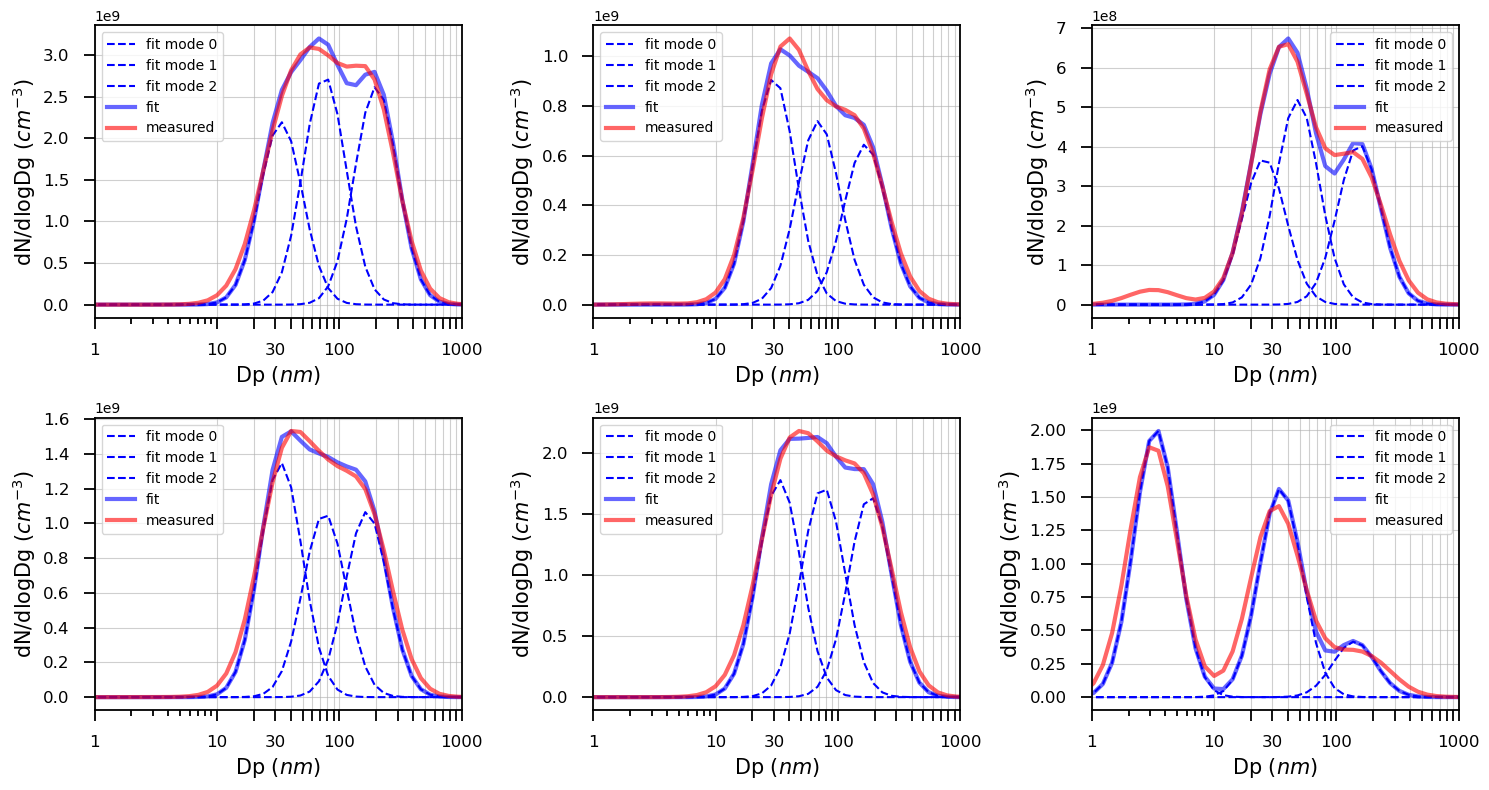

In [46]:
fig = plt.figure(num=None, figsize=(15,8))
for i in range(0,6):
    distributions = [log_distrib(Dpg[i][j],sig[j],Ntot[i][j],Dp_) for j in range(len(Dpg[i]))]
    ax = fig.add_subplot(2,3, i+1)
    plot_fit(Dp_*1e9, myds_med.sel(label = i), distributions, ax)
fig.tight_layout()

In [47]:
Means_ds

<xarray.Dataset> Size: 312B
Dimensions:      (KmeansLabel: 6, Distribution Number: 3)
Dimensions without coordinates: KmeansLabel, Distribution Number
Data variables:
    Dpg          (KmeansLabel, Distribution Number) float64 144B 3.336e-08 .....
    Ntot         (KmeansLabel, Distribution Number) float64 144B 9.679e+08 .....
    Temperature  (KmeansLabel) float32 24B 263.2 278.2 280.1 274.6 268.2 285.4

In [48]:
!rm /share/pech2273/ECearthKmeans.nc
Means_ds.to_netcdf('/share/pech2273/ECearthKmeans.nc')

In [49]:
myds['label'].where(PeterIFS_ds['var130'].isel(lev = 0).dropna('time')>0)

<xarray.DataArray 'label' (time: 19959)> Size: 160kB
array([4., 4., 4., ..., 4., 4., 3.], shape=(19959,))
Coordinates:
  * time       (time) datetime64[ns] 160kB 2012-01-01T03:00:00 ... 2018-12-31...
    lev        float32 4B 998.9
    station    <U6 24B 'SMR-II'
    time_orig  (time) datetime64[ns] 160kB 2012-01-01T03:30:00 ... 2018-12-31...
    Dx         float64 8B 0.03765

In [50]:
Temp_ds2 = PeterIFS_ds['var130'].reindex(time = myds['time'])
Temp_ds2

<xarray.DataArray 'var130' (time: 59903, lev: 34)> Size: 8MB
[2036702 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 479kB 2012-01-01 ... 2018-12-31T23:00:00
  * lev        (lev) float32 136B 998.9 987.3 964.2 ... 1.405 0.4877 0.1071
    station    <U6 24B ...
    time_orig  (time) datetime64[ns] 479kB ...
Attributes:
    table:             128
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  128

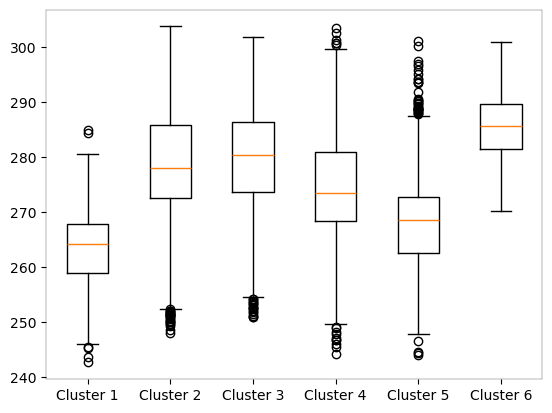

In [51]:
plt.boxplot([Temp_ds2.dropna('time').isel(lev = 0).where(myds['label'] == 0, drop = True),Temp_ds2.dropna('time').isel(lev = 0).where(myds['label'] == 1, drop = True),\
            Temp_ds2.dropna('time').isel(lev = 0).where(myds['label'] == 2, drop = True),Temp_ds2.dropna('time').isel(lev = 0).where(myds['label'] == 3, drop = True),\
            Temp_ds2.dropna('time').isel(lev = 0).where(myds['label'] == 4, drop = True),Temp_ds2.dropna('time').isel(lev = 0).where(myds['label'] == 5, drop = True)],
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])
plt.show()

In [52]:
ECMassFrac_ds = xr.open_dataset("/share/pech2273/ECMassFrac.nc")

In [53]:
BCECMassFracMeans = ECMassFrac_ds['BCMassFrac'].dropna('time').isel(lev = 0).groupby(myds['label']).mean()
OAECMassFracMeans = ECMassFrac_ds['OAMassFrac'].dropna('time').isel(lev = 0).groupby(myds['label']).mean()
SO4ECMassFracMeans = ECMassFrac_ds['SO4MassFrac'].dropna('time').isel(lev = 0).groupby(myds['label']).mean()
SeasaltECMassFracMeans = ECMassFrac_ds['SeasaltMassFrac'].dropna('time').isel(lev = 0).groupby(myds['label']).mean()
DustECMassFracMeans = ECMassFrac_ds['DustMassFrac'].dropna('time').isel(lev = 0).groupby(myds['label']).mean()

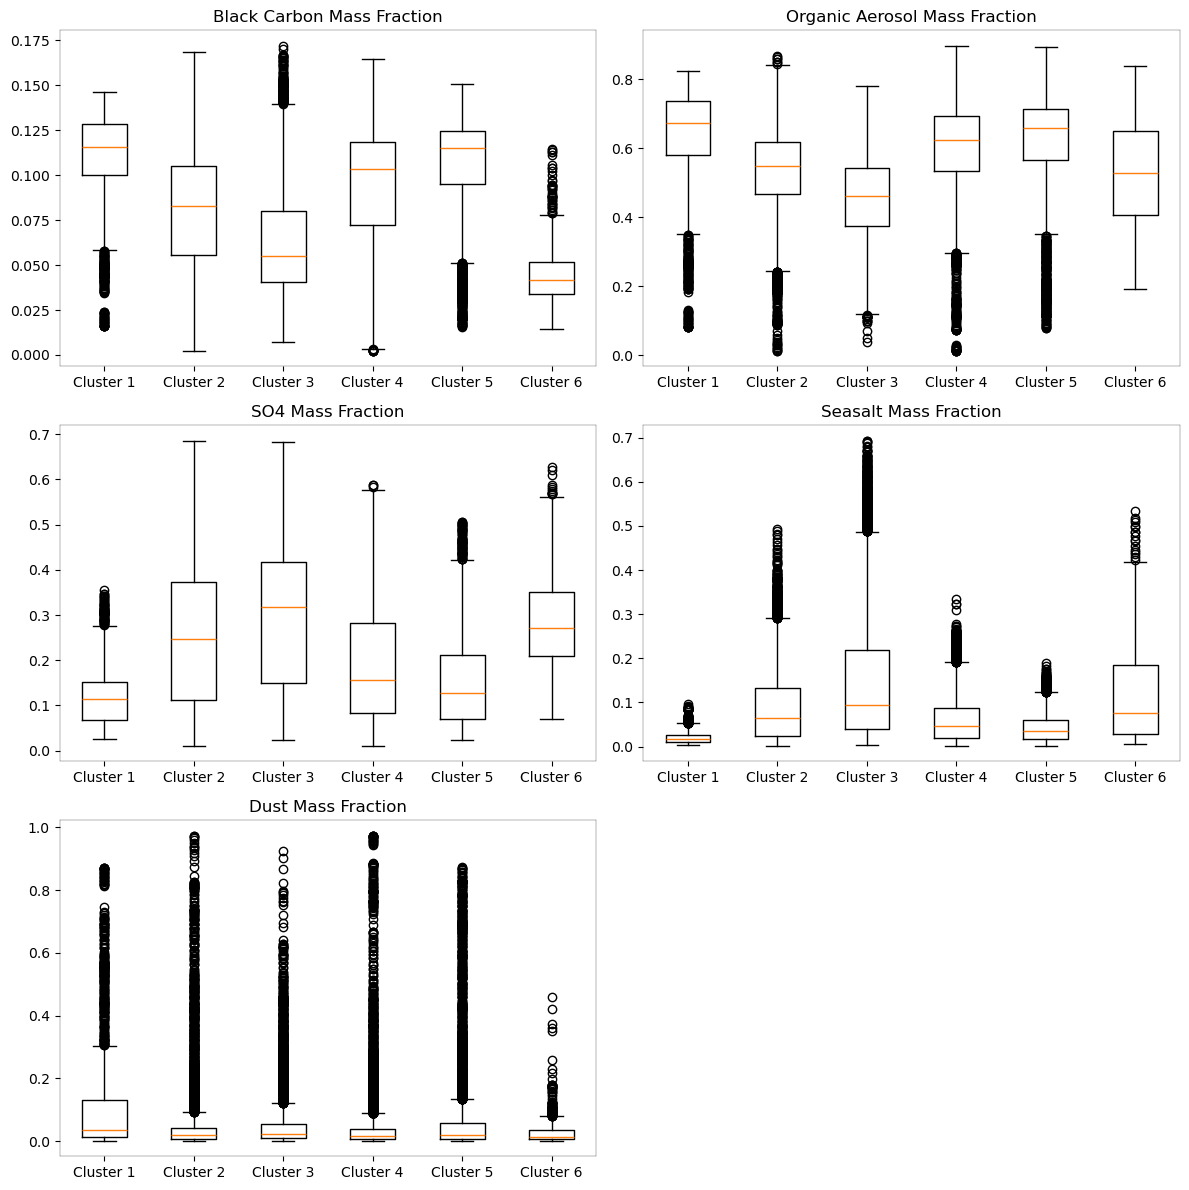

In [54]:
plt.figure(figsize = (12,12))
plt.subplot(3,2,1)
plt.title('Black Carbon Mass Fraction')
plt.boxplot([ECMassFrac_ds['BCMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 0, drop = True),ECMassFrac_ds['BCMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 1, drop = True),\
            ECMassFrac_ds['BCMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 2, drop = True),ECMassFrac_ds['BCMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 3, drop = True),\
            ECMassFrac_ds['BCMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 4, drop = True),ECMassFrac_ds['BCMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 5, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])
plt.subplot(3,2,2)
plt.title('Organic Aerosol Mass Fraction')
plt.boxplot([ECMassFrac_ds['OAMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 0, drop = True),ECMassFrac_ds['OAMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 1, drop = True),\
            ECMassFrac_ds['OAMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 2, drop = True),ECMassFrac_ds['OAMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 3, drop = True),\
            ECMassFrac_ds['OAMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 4, drop = True),ECMassFrac_ds['OAMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 5, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])
plt.subplot(3,2,3)
plt.title('SO4 Mass Fraction')
plt.boxplot([ECMassFrac_ds['SO4MassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 0, drop = True),ECMassFrac_ds['SO4MassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 1, drop = True),\
            ECMassFrac_ds['SO4MassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 2, drop = True),ECMassFrac_ds['SO4MassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 3, drop = True),\
            ECMassFrac_ds['SO4MassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 4, drop = True),ECMassFrac_ds['SO4MassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 5, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])
plt.subplot(3,2,4)
plt.title('Seasalt Mass Fraction')
plt.boxplot([ECMassFrac_ds['SeasaltMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 0, drop = True),ECMassFrac_ds['SeasaltMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 1, drop = True),\
            ECMassFrac_ds['SeasaltMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 2, drop = True),ECMassFrac_ds['SeasaltMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 3, drop = True),\
            ECMassFrac_ds['SeasaltMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 4, drop = True),ECMassFrac_ds['SeasaltMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 5, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])
plt.subplot(3,2,5)
plt.title('Dust Mass Fraction')
plt.boxplot([ECMassFrac_ds['DustMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 0, drop = True),ECMassFrac_ds['DustMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 1, drop = True),\
            ECMassFrac_ds['DustMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 2, drop = True),ECMassFrac_ds['DustMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 3, drop = True),\
            ECMassFrac_ds['DustMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 4, drop = True),ECMassFrac_ds['DustMassFrac'].dropna('time').isel(lev = 0).where(myds['label'] == 5, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])
plt.tight_layout()
plt.show()

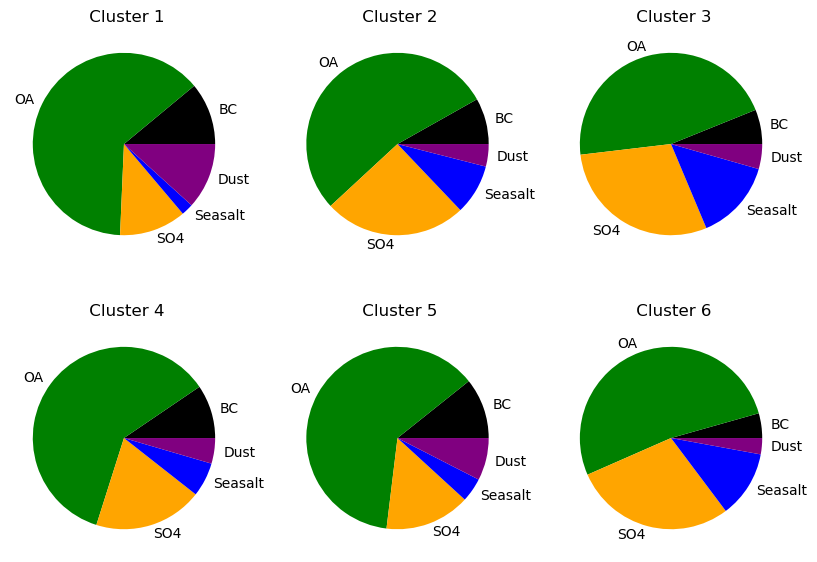

In [55]:
fig = plt.figure(figsize = (10,7))
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.title(f' Cluster {i}')
    plt.pie([BCECMassFracMeans[i-1],OAECMassFracMeans[i-1],SO4ECMassFracMeans[i-1], SeasaltECMassFracMeans[i-1], DustECMassFracMeans[i-1]], labels = ['BC','OA','SO4','Seasalt', 'Dust'], colors=['black', 'green','orange','blue','purple'])
plt.show()

In [56]:
ECMassFracMeans_ds = xr.Dataset({'BCMassFrac' : BCECMassFracMeans, 'OAMassFrac' :OAECMassFracMeans,'SO4MassFrac' : SO4ECMassFracMeans, 'SeasaltMassFrac' :SeasaltECMassFracMeans, 'DustMassFrac' :DustECMassFracMeans})

In [57]:
!rm /share/pech2273/ECMassFracforPARSEC.nc

ECMassFracMeans_ds.to_netcdf('/share/pech2273/ECMassFracforPARSEC.nc')

In [79]:
CDNC_ds = xr.open_dataset('/share/pech2273/ECCDNCParsec.nc')
myds['DropletsCCUp1'] = PeterIFS_ds['Droplets'].reindex(time = myds['time'])
myds['DropletsCCUp2'] = PeterIFS_ds['Droplets'].reindex(time = myds['time'])
myds['DropletsCCUp3'] = PeterIFS_ds['Droplets'].reindex(time = myds['time'])
myds['Droplets'] = PeterIFS_ds['Droplets'].reindex(time = myds['time'])
myds['ActivatedNumberUpdraft1'] = Peter_ds['TotalN70'].reindex(time = myds['time'])
myds['ActivatedNumberUpdraft1CC']= Peter_ds['TotalN70'].reindex(time = myds['time'])
myds['ActivatedNumberUpdraft2']= Peter_ds['TotalN70'].reindex(time = myds['time'])
myds['ActivatedNumberUpdraft2CC']=Peter_ds['TotalN70'].reindex(time = myds['time'])
myds['ActivatedNumberUpdraft3']= Peter_ds['TotalN70'].reindex(time = myds['time'])
myds['ActivatedNumberUpdraft3CC']= Peter_ds['TotalN70'].reindex(time = myds['time'])
myds['Tot_dis'] = Peter_ds['Tot_dis'].reindex(time = myds['time'])
myds['TotN70'] = Peter_ds['TotalN70'].reindex(time = myds['time'])
myds['T'] = PeterIFS_ds['var130'].reindex(time = myds['time']).ffill('time')

In [80]:
CDNC_ds['Percentage_Increase'].values

array([        nan,  7.        ,  9.66183575,  5.83756345, 12.5       ,
       11.61616162, 24.87205732, 15.61181435, 21.45214521, 13.4375    ,
       10.05025126, 38.03278689, 33.66418528, 20.03546099, 20.50561798,
       15.53884712, 14.1       , 35.78947368])

In [81]:
ActivationRadius = [np.nan,
 np.float64(203.16583101639702),
 np.float64(141.33523429255584),
 np.float64(251.5108263233402),
 np.float64(304.7839531499037),
 np.float64(141.33523429255584),
 np.float64(268.14425005353365),
 np.float64(124.34457265169122),
 np.float64(92.22282316159196),
 np.float64(160.6475298965127),
 np.float64(203.16583101639702),
 np.float64(96.24531891583946),
 np.float64(207.54929878718698),
 np.float64(98.3218898207321),
 np.float64(76.1032141604749),
 np.float64(121.71839935273819),
 np.float64(157.25463349130524),
 np.float64(81.13622616582478)]

ActivationRadius_CC = [np.nan,
 np.float64(190.56312424898383),
 np.float64(127.02740777196964),
 np.float64(240.99913346981475),
 np.float64(285.87770907458366),
 np.float64(127.02740777196964),
 np.float64(207.54929878718698),
 np.float64(102.61040941702),
 np.float64(72.92254148679628),
 np.float64(141.33523429255584),
 np.float64(186.53840665982455),
 np.float64(77.74520280028237),
 np.float64(144.38465673381506),
 np.float64(74.49590453102621),
 np.float64(57.66139958192239),
 np.float64(98.3218898207321),
 np.float64(132.5679799526813),
 np.float64(64.15613419567872)]

In [82]:
for i in range(6):
    if i == 0:
        mask = myds['label'] == i  
        myds['DropletsCCUp1'] = xr.where( mask, np.nan, myds['DropletsCCUp1'])
        continue
    mask = myds['label'] == i  
    myds['DropletsCCUp1'] = xr.where( mask, myds['Droplets']*(1+CDNC_ds['Percentage_Increase'][i]/100), myds['DropletsCCUp1'])
for i in range(6):
    if i == 0:
        mask = myds['label'] == i  
        myds['DropletsCCUp2'] = xr.where( mask, np.nan, myds['DropletsCCUp2'])
        continue
    mask = myds['label'] == i  
    myds['DropletsCCUp2'] = xr.where(mask, myds['Droplets']* (1+CDNC_ds['Percentage_Increase'][i+6]/100), myds['DropletsCCUp2'])
for i in range(6):
    if i == 0:
        mask = myds['label'] == i  
        myds['DropletsCCUp3'] = xr.where( mask, np.nan, myds['DropletsCCUp3'])
        continue
    mask = myds['label'] == i  
    myds['DropletsCCUp3'] = xr.where(mask, myds['Droplets']* (1+CDNC_ds['Percentage_Increase'][i+12]/100), myds['DropletsCCUp3'])

In [83]:
for i in range(6):
    if i == 0:
        mask = myds['label'] == i  
        myds['ActivatedNumberUpdraft1'] = xr.where( mask, np.nan, myds['ActivatedNumberUpdraft1']) 
        myds['ActivatedNumberUpdraft1CC'] = xr.where( mask, np.nan, myds['ActivatedNumberUpdraft1CC']) 
        continue
    mask = myds['label'] == i 
    print(i)
    myds['ActivatedNumberUpdraft1'] = xr.where( mask, myds['Tot_dis'].where(Peter_ds['D']>ActivationRadius[i]).sum('D')*dx[0], myds['ActivatedNumberUpdraft1'])
    myds['ActivatedNumberUpdraft1CC'] = xr.where( mask, myds['Tot_dis'].where(Peter_ds['D']>ActivationRadius_CC[i]).sum('D')*dx[0], myds['ActivatedNumberUpdraft1CC'])

for i in range(6):
    if i == 0:
        mask = myds['label'] == i  
        myds['ActivatedNumberUpdraft2'] = xr.where( mask, np.nan, myds['ActivatedNumberUpdraft2']) 
        myds['ActivatedNumberUpdraft2CC'] = xr.where( mask, np.nan, myds['ActivatedNumberUpdraft2CC'])  
        continue
    mask = myds['label'] == i  
    myds['ActivatedNumberUpdraft2'] = xr.where( mask, myds['Tot_dis'].where(myds['D']>ActivationRadius[i+6]).sum('D')*dx[0], myds['ActivatedNumberUpdraft2'])
    myds['ActivatedNumberUpdraft2CC'] = xr.where( mask, myds['Tot_dis'].where(myds['D']>ActivationRadius_CC[i+6]).sum('D')*dx[0], myds['ActivatedNumberUpdraft2CC'])

for i in range(6):
    if i == 0:
        mask = myds['label'] == i  
        myds['ActivatedNumberUpdraft3'] = xr.where( mask, np.nan, myds['ActivatedNumberUpdraft3']) 
        myds['ActivatedNumberUpdraft3CC'] = xr.where( mask, np.nan, myds['ActivatedNumberUpdraft3CC'])  
        continue
    mask = myds['label'] == i  
    myds['ActivatedNumberUpdraft3'] = xr.where( mask, myds['Tot_dis'].where(myds['D']>ActivationRadius[i+12]).sum('D')*dx[0], myds['ActivatedNumberUpdraft3'])
    myds['ActivatedNumberUpdraft3CC'] = xr.where( mask, myds['Tot_dis'].where(myds['D']>ActivationRadius_CC[i+12]).sum('D')*dx[0], myds['ActivatedNumberUpdraft3CC'])

1
2
3
4
5


In [84]:
!rm /share/pech2273/ECEarthProcessed.nc
myds.to_netcdf('/share/pech2273/ECEarthProcessed.nc')


In [64]:
def Susceptibility(x, y):
    x = x.to_numpy()
    y = y.to_numpy()
    Y = np.log10(y)
    X = np.log10(x)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    parameters = model.params
    sterrs = model.bse
    S = parameters[1]
    Sterr = sterrs[1]
    return S, Sterr

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     5934.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:06:49   Log-Likelihood:                 2807.6
No. Observations:                6918   AIC:                            -5611.
Df Residuals:                    6916   BIC:                            -5598.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6266      0.022     28.656      0.0

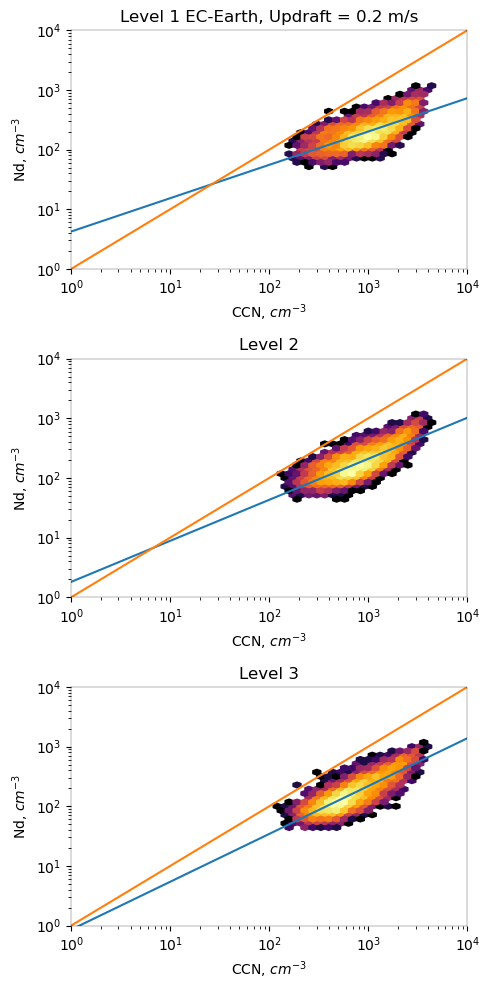

In [65]:
plt.figure(figsize = (5,10))
x = Peter_ds['TotalN70'].isel(lev = 0).where(myds['DropletsCCUp1'].isel(lev =0)>0).dropna('time')/10**6
y = myds['DropletsCCUp1'].isel(lev = 0).where(myds['DropletsCCUp1'].isel(lev =0)>0).dropna('time')
plt.subplot(3,1,1)
SCCUp1Lev1 = Susceptibility(x,y)
plt.title('Level 1 EC-Earth, Updraft = 0.2 m/s')
NdtoCCNGraph(x,y)
x =Peter_ds['TotalN70'].isel(lev = 1).where(myds['DropletsCCUp1'].isel(lev =1)>0).dropna('time')/10**6
y = myds['DropletsCCUp1'].isel(lev = 1).where(myds['DropletsCCUp1'].isel(lev =1)>0).dropna('time')
plt.subplot(3,1,2)
SCCUp1Lev2 = Susceptibility(x,y)
plt.title('Level 2')
NdtoCCNGraph(x,y)
x = Peter_ds['TotalN70'].isel(lev = 2).where(myds['DropletsCCUp1'].isel(lev =2)>0).dropna('time')/10**6
y = myds['DropletsCCUp1'].isel(lev = 2).where(myds['DropletsCCUp1'].isel(lev =2)>0).dropna('time')
plt.subplot(3,1,3)
SCCUp1Lev3 = Susceptibility(x,y)
plt.title('Level 3')
NdtoCCNGraph(x,y)
plt.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     5053.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:06:56   Log-Likelihood:                 2889.5
No. Observations:                6918   AIC:                            -5775.
Df Residuals:                    6916   BIC:                            -5761.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8071      0.022     37.348      0.0

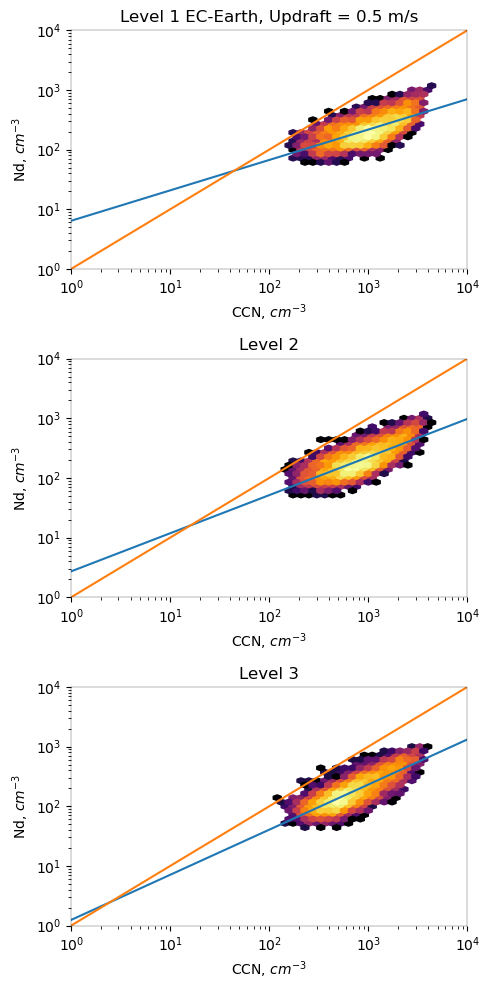

In [66]:
plt.figure(figsize = (5,10))
x = Peter_ds['TotalN70'].isel(lev = 0).where(myds['DropletsCCUp2'].isel(lev =0)>0).dropna('time')/10**6
y = myds['DropletsCCUp2'].isel(lev = 0).where(myds['DropletsCCUp2'].isel(lev =0)>0).dropna('time')
plt.subplot(3,1,1)
SCCUp2Lev1 = Susceptibility(x,y)
plt.title('Level 1 EC-Earth, Updraft = 0.5 m/s')

NdtoCCNGraph(x,y)
x =Peter_ds['TotalN70'].isel(lev = 1).where(myds['DropletsCCUp2'].isel(lev =1)>0).dropna('time')/10**6
y = myds['DropletsCCUp2'].isel(lev = 1).where(myds['DropletsCCUp2'].isel(lev =1)>0).dropna('time')
plt.subplot(3,1,2)
SCCUp2Lev2 = Susceptibility(x,y)
plt.title('Level 2')

NdtoCCNGraph(x,y)
x = Peter_ds['TotalN70'].isel(lev = 2).where(myds['DropletsCCUp2'].isel(lev =2)>0).dropna('time')/10**6
y = myds['DropletsCCUp2'].isel(lev = 2).where(myds['DropletsCCUp2'].isel(lev =2)>0).dropna('time')
plt.subplot(3,1,3)
SCCUp2Lev3 = Susceptibility(x,y)
plt.title('Level 3')

NdtoCCNGraph(x,y)
plt.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     5496.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:07:03   Log-Likelihood:                 2906.0
No. Observations:                6918   AIC:                            -5808.
Df Residuals:                    6916   BIC:                            -5794.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7532      0.022     34.937      0.0

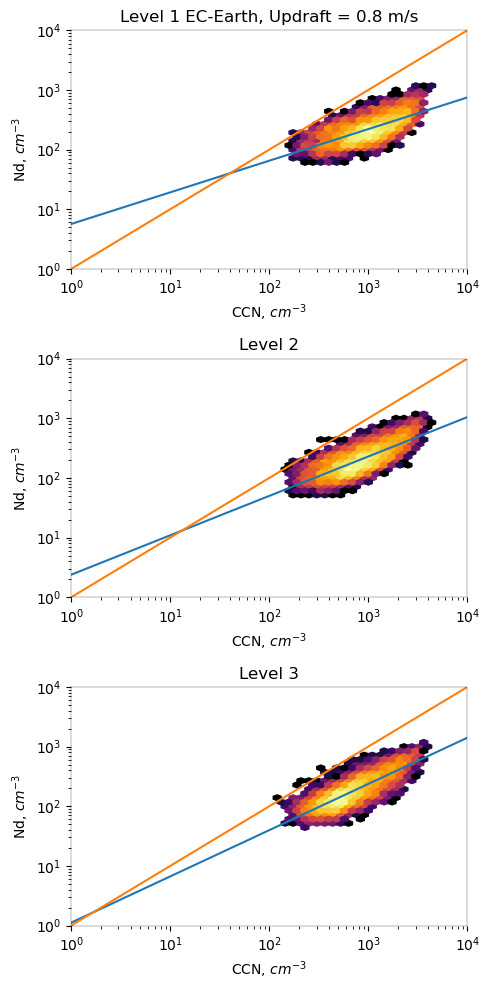

In [67]:
plt.figure(figsize = (5,10))
x = Peter_ds['TotalN70'].isel(lev = 0).where(myds['DropletsCCUp3'].isel(lev =0)>0).dropna('time')/10**6
y = myds['DropletsCCUp3'].isel(lev = 0).where(myds['DropletsCCUp3'].isel(lev =0)>0).dropna('time')
plt.subplot(3,1,1)
SCCUp3Lev1 = Susceptibility(x,y)
plt.title('Level 1 EC-Earth, Updraft = 0.8 m/s')


NdtoCCNGraph(x,y)
x =Peter_ds['TotalN70'].isel(lev = 1).where(myds['DropletsCCUp3'].isel(lev =1)>0).dropna('time')/10**6
y = myds['DropletsCCUp3'].isel(lev = 1).where(myds['DropletsCCUp3'].isel(lev =1)>0).dropna('time')
plt.subplot(3,1,2)
SCCUp3Lev2 = Susceptibility(x,y)
plt.title('Level 2')
NdtoCCNGraph(x,y)
x = Peter_ds['TotalN70'].isel(lev = 2).where(myds['DropletsCCUp3'].isel(lev =2)>0).dropna('time')/10**6
y = myds['DropletsCCUp3'].isel(lev = 2).where(myds['DropletsCCUp3'].isel(lev =2)>0).dropna('time')
plt.subplot(3,1,3)
SCCUp3Lev3 = Susceptibility(x,y)
plt.title('Level 3')

NdtoCCNGraph(x,y)
plt.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     7711.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:07:10   Log-Likelihood:                 2900.5
No. Observations:                7095   AIC:                            -5797.
Df Residuals:                    7093   BIC:                            -5783.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4876      0.021     23.745      0.0

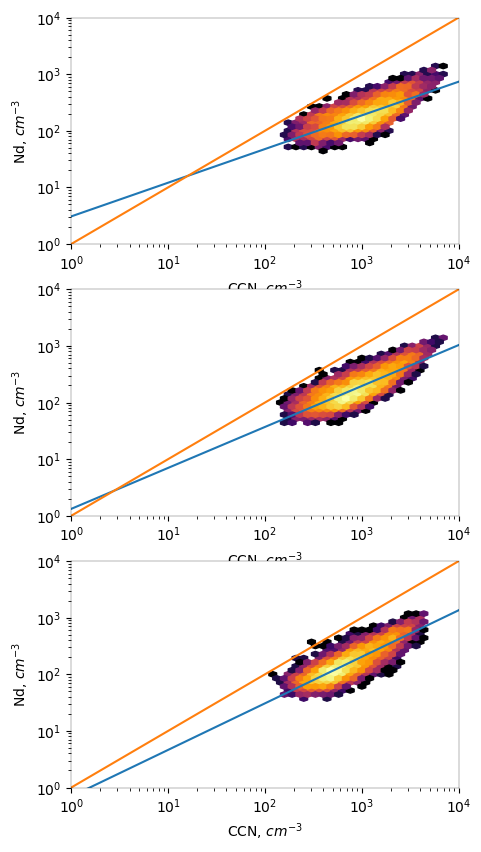

In [68]:
plt.figure(figsize = (5,10))
x = Peter_ds['TotalN70'].isel(lev = 0).where(myds['Droplets'].isel(lev =0)>0).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 0).where(myds['Droplets'].isel(lev =0)>0).dropna('time')
plt.subplot(3,1,1)
SBaseLev1 = Susceptibility(x,y)

NdtoCCNGraph(x,y)
x =Peter_ds['TotalN70'].isel(lev = 1).where(myds['Droplets'].isel(lev =1)>0).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 1).where(myds['Droplets'].isel(lev =1)>0).dropna('time')
plt.subplot(3,1,2)
SBaseLev2 = Susceptibility(x,y)

NdtoCCNGraph(x,y)
x = Peter_ds['TotalN70'].isel(lev = 2).where(myds['Droplets'].isel(lev =2)>0).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 2).where(myds['Droplets'].isel(lev =2)>0).dropna('time')
plt.subplot(3,1,3)
SBaseLev3 = Susceptibility(x,y)

NdtoCCNGraph(x,y)

In [69]:
ArrayList = [SBaseLev1, SCCUp1Lev1, SCCUp2Lev1, SCCUp3Lev1]
SusceptibilityLev1_df = pd.DataFrame(np.vstack(ArrayList))
SusceptibilityLev1_df = SusceptibilityLev1_df.T
SusceptibilityLev1_df.columns = ['Base', 'CC & Updraft 1', 'CC & Updraft 2', 'CC & Updraft 3']
SusceptibilityLev1_df.index = ['Susceptibility', 'Standard Error']
SusceptibilityLev1_df

,Base,CC & Updraft 1,CC & Updraft 2,CC & Updraft 3
Susceptibility,0.594904,0.558874,0.509625,0.530242
Standard Error,0.006775,0.007255,0.007169,0.007152


In [70]:
ArrayList = [SBaseLev2, SCCUp1Lev2, SCCUp2Lev2, SCCUp3Lev2]
SusceptibilityLev2_df = pd.DataFrame(np.vstack(ArrayList))
SusceptibilityLev2_df = SusceptibilityLev2_df.T
SusceptibilityLev2_df.columns = ['Base', 'CC & Updraft 1', 'CC & Updraft 2', 'CC & Updraft 3']
SusceptibilityLev2_df.index = ['Susceptibility', 'Standard Error']
SusceptibilityLev2_df

,Base,CC & Updraft 1,CC & Updraft 2,CC & Updraft 3
Susceptibility,0.723432,0.687874,0.638861,0.660546
Standard Error,0.005002,0.005516,0.005504,0.005474


In [71]:
ArrayList = [SBaseLev3, SCCUp1Lev3, SCCUp2Lev3, SCCUp3Lev3]
SusceptibilityLev3_df = pd.DataFrame(np.vstack(ArrayList))
SusceptibilityLev3_df = SusceptibilityLev3_df.T
SusceptibilityLev3_df.columns = ['Base', 'CC & Updraft 1', 'CC & Updraft 2', 'CC & Updraft 3']
SusceptibilityLev3_df.index = ['Susceptibility', 'Standard Error']
SusceptibilityLev3_df

,Base,CC & Updraft 1,CC & Updraft 2,CC & Updraft 3
Susceptibility,0.822300,0.802131,0.756303,0.775149
Standard Error,0.004615,0.004927,0.004952,0.004922


In [72]:
x = myds['ActivatedNumberUpdraft1'].isel(lev = 0).where(myds['ActivatedNumberUpdraft1'].isel(lev =0)>0).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 0).where(myds['ActivatedNumberUpdraft1'].isel(lev =0)>0).dropna('time')
len(x)

57894

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     918.4
Date:                Thu, 27 Feb 2025   Prob (F-statistic):          1.56e-189
Time:                        16:07:14   Log-Likelihood:                 1097.0
No. Observations:                6918   AIC:                            -2190.
Df Residuals:                    6916   BIC:                            -2176.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1006      0.039     28.454      0.0

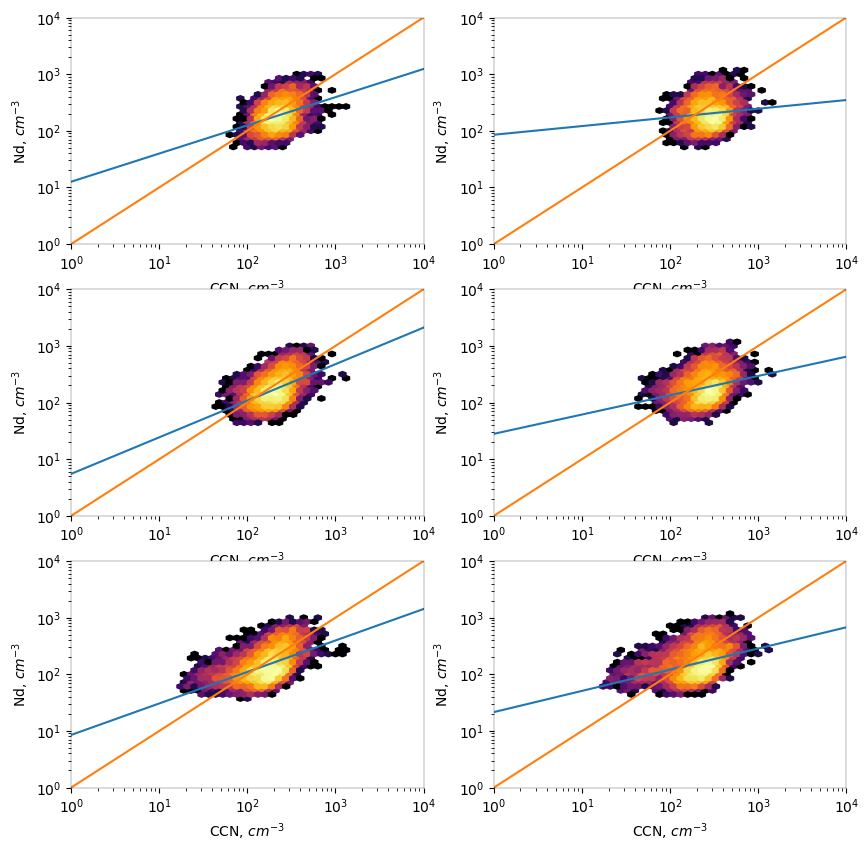

In [73]:
plt.figure(figsize = (10,10))

x = myds['ActivatedNumberUpdraft1'].isel(lev = 0).where((myds['Droplets'].isel(lev =0)>0)&(myds['ActivatedNumberUpdraft1'].isel(lev =0)>0)).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 0).where((myds['Droplets'].isel(lev =0)>0)&(myds['ActivatedNumberUpdraft1'].isel(lev =0)>0)).dropna('time')

plt.subplot(3,2,1)
NdtoCCNGraph(x,y)
SActUp1Lev1 = Susceptibility(x,y)
x = myds['ActivatedNumberUpdraft1CC'].isel(lev = 0).where(myds['DropletsCCUp1'].isel(lev =0)>0).dropna('time')/10**6
y = myds['DropletsCCUp1'].isel(lev = 0).where(myds['DropletsCCUp1'].isel(lev =0)>0).dropna('time')

plt.subplot(3,2,2)
NdtoCCNGraph(x,y)
SActCCUp1Lev1 = Susceptibility(x,y)

x = myds['ActivatedNumberUpdraft1'].isel(lev = 1).where((myds['Droplets'].isel(lev =1)>0)&(myds['ActivatedNumberUpdraft1'].isel(lev =1)>0)).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 1).where((myds['Droplets'].isel(lev =1)>0)&(myds['ActivatedNumberUpdraft1'].isel(lev =1)>0)).dropna('time')

plt.subplot(3,2,3)
SActUp1Lev2 = Susceptibility(x,y)
NdtoCCNGraph(x,y)

x = myds['ActivatedNumberUpdraft1CC'].isel(lev = 1).where(myds['DropletsCCUp1'].isel(lev =1)>0).dropna('time')/10**6
y = myds['DropletsCCUp1'].isel(lev = 1).where(myds['DropletsCCUp1'].isel(lev =1)>0).dropna('time')

plt.subplot(3,2,4)
NdtoCCNGraph(x,y)
SActCCUp1Lev2 = Susceptibility(x,y)

x = myds['ActivatedNumberUpdraft1'].isel(lev = 2).where((myds['Droplets'].isel(lev =2)>0)&(myds['ActivatedNumberUpdraft1'].isel(lev =2)>0)).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 2).where((myds['Droplets'].isel(lev =2)>0)&(myds['ActivatedNumberUpdraft1'].isel(lev =2)>0)).dropna('time')

plt.subplot(3,2,5)
SActUp1Lev3 = Susceptibility(x,y)
NdtoCCNGraph(x,y)

x = myds['ActivatedNumberUpdraft1CC'].isel(lev = 2).where(myds['DropletsCCUp1'].isel(lev =2)>0).dropna('time')/10**6
y = myds['DropletsCCUp1'].isel(lev = 2).where(myds['DropletsCCUp1'].isel(lev =2)>0).dropna('time')

plt.subplot(3,2,6)
NdtoCCNGraph(x,y)
SActCCUp1Lev3 = Susceptibility(x,y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     3480.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:07:16   Log-Likelihood:                 2075.6
No. Observations:                6918   AIC:                            -4147.
Df Residuals:                    6916   BIC:                            -4133.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0186      0.038      0.487      0.6

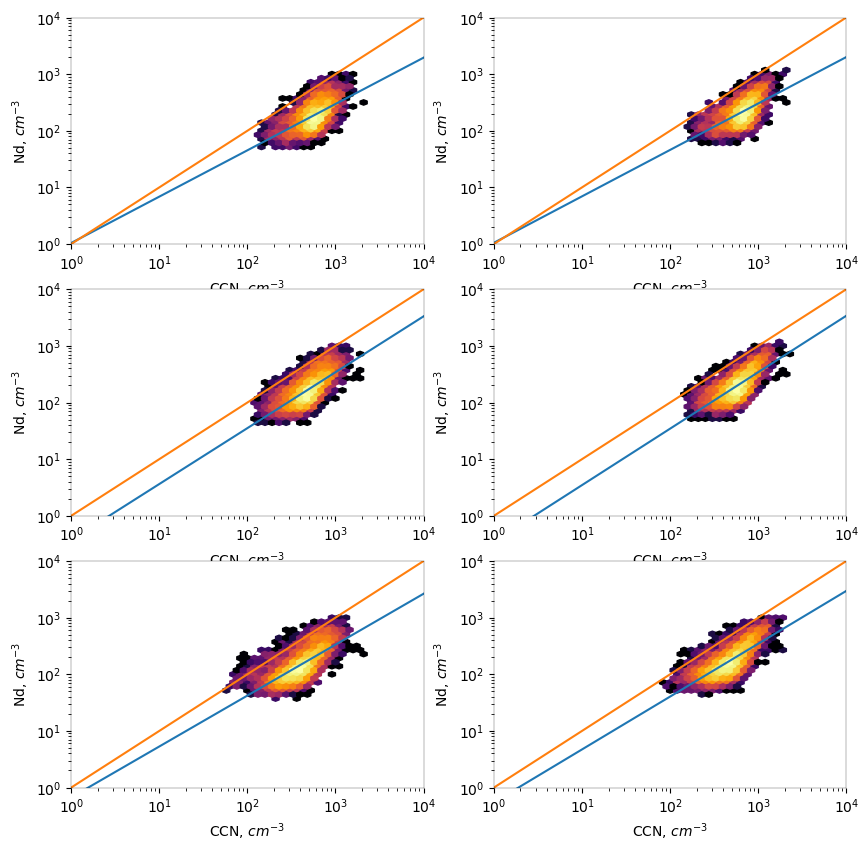

In [74]:
plt.figure(figsize = (10,10))

x = myds['ActivatedNumberUpdraft2'].isel(lev = 0).where((myds['Droplets'].isel(lev =0)>0)&(myds['ActivatedNumberUpdraft2'].isel(lev =0)>0)).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 0).where((myds['Droplets'].isel(lev =0)>0)&(myds['ActivatedNumberUpdraft2'].isel(lev =0)>0)).dropna('time')

plt.subplot(3,2,1)
NdtoCCNGraph(x,y)
SActUp2Lev1 = Susceptibility(x,y)
x = myds['ActivatedNumberUpdraft2CC'].isel(lev = 0).where(myds['DropletsCCUp2'].isel(lev =0)>0).dropna('time')/10**6
y = myds['DropletsCCUp2'].isel(lev = 0).where(myds['DropletsCCUp2'].isel(lev =0)>0).dropna('time')

plt.subplot(3,2,2)
NdtoCCNGraph(x,y)
SActCCUp2Lev1 = Susceptibility(x,y)

x = myds['ActivatedNumberUpdraft2'].isel(lev = 1).where((myds['Droplets'].isel(lev =1)>0)&(myds['ActivatedNumberUpdraft2'].isel(lev =1)>0)).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 1).where((myds['Droplets'].isel(lev =1)>0)&(myds['ActivatedNumberUpdraft2'].isel(lev =1)>0)).dropna('time')

plt.subplot(3,2,3)
SActUp2Lev2 = Susceptibility(x,y)
NdtoCCNGraph(x,y)

x = myds['ActivatedNumberUpdraft2CC'].isel(lev = 1).where(myds['DropletsCCUp2'].isel(lev =1)>0).dropna('time')/10**6
y = myds['DropletsCCUp2'].isel(lev = 1).where(myds['DropletsCCUp2'].isel(lev =1)>0).dropna('time')

plt.subplot(3,2,4)
NdtoCCNGraph(x,y)
SActCCUp2Lev2 = Susceptibility(x,y)

x = myds['ActivatedNumberUpdraft2'].isel(lev = 2).where((myds['Droplets'].isel(lev =2)>0)&(myds['ActivatedNumberUpdraft2'].isel(lev =2)>0)).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 2).where((myds['Droplets'].isel(lev =2)>0)&(myds['ActivatedNumberUpdraft2'].isel(lev =2)>0)).dropna('time')

plt.subplot(3,2,5)
SActUp2Lev3 = Susceptibility(x,y)
NdtoCCNGraph(x,y)

x = myds['ActivatedNumberUpdraft2CC'].isel(lev = 2).where(myds['DropletsCCUp2'].isel(lev =2)>0).dropna('time')/10**6
y = myds['DropletsCCUp2'].isel(lev = 2).where(myds['DropletsCCUp2'].isel(lev =2)>0).dropna('time')

plt.subplot(3,2,6)
NdtoCCNGraph(x,y)
SActCCUp2Lev3 = Susceptibility(x,y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     6133.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:07:18   Log-Likelihood:                 2861.6
No. Observations:                6918   AIC:                            -5719.
Df Residuals:                    6916   BIC:                            -5706.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1151      0.031     -3.771      0.0

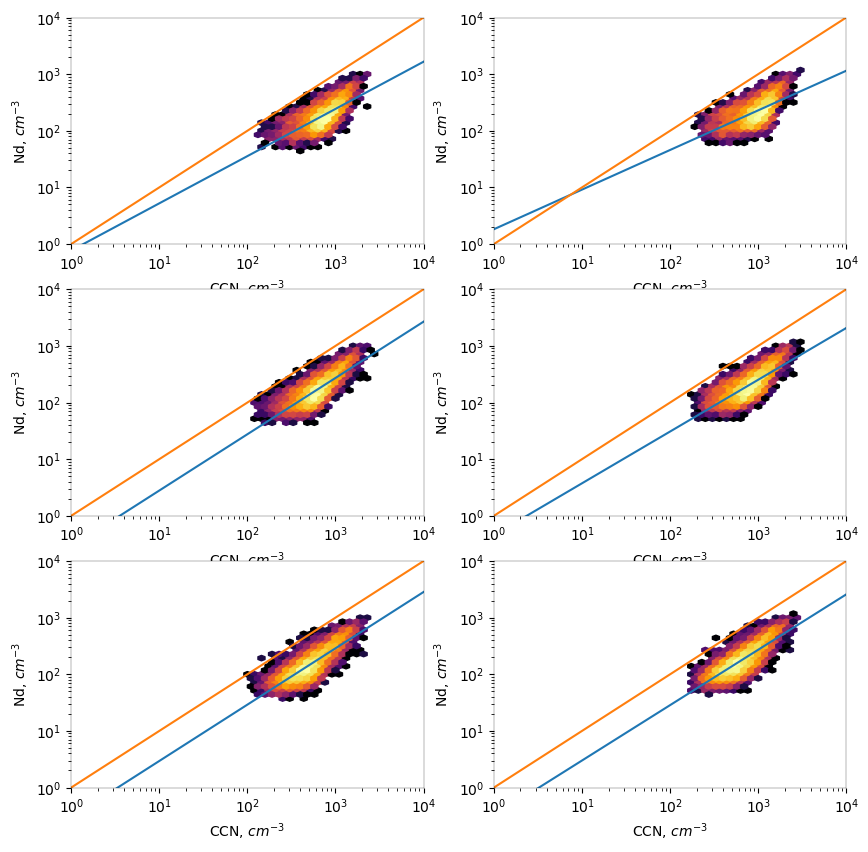

In [75]:
plt.figure(figsize = (10,10))

x = myds['ActivatedNumberUpdraft3'].isel(lev = 0).where((myds['Droplets'].isel(lev =0)>0)&(myds['ActivatedNumberUpdraft3'].isel(lev =0)>0)).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 0).where((myds['Droplets'].isel(lev =0)>0)&(myds['ActivatedNumberUpdraft3'].isel(lev =0)>0)).dropna('time')

plt.subplot(3,2,1)
NdtoCCNGraph(x,y)
SActUp3Lev1 = Susceptibility(x,y)
x = myds['ActivatedNumberUpdraft3CC'].isel(lev = 0).where(myds['DropletsCCUp3'].isel(lev =0)>0).dropna('time')/10**6
y = myds['DropletsCCUp2'].isel(lev = 0).where(myds['DropletsCCUp3'].isel(lev =0)>0).dropna('time')

plt.subplot(3,2,2)
NdtoCCNGraph(x,y)
SActCCUp3Lev1 = Susceptibility(x,y)

x = myds['ActivatedNumberUpdraft3'].isel(lev = 1).where((myds['Droplets'].isel(lev =1)>0)&(myds['ActivatedNumberUpdraft3'].isel(lev =1)>0)).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 1).where((myds['Droplets'].isel(lev =1)>0)&(myds['ActivatedNumberUpdraft3'].isel(lev =1)>0)).dropna('time')

plt.subplot(3,2,3)
SActUp3Lev2 = Susceptibility(x,y)
NdtoCCNGraph(x,y)

x = myds['ActivatedNumberUpdraft3CC'].isel(lev = 1).where(myds['DropletsCCUp3'].isel(lev =1)>0).dropna('time')/10**6
y = myds['DropletsCCUp3'].isel(lev = 1).where(myds['DropletsCCUp3'].isel(lev =1)>0).dropna('time')

plt.subplot(3,2,4)
NdtoCCNGraph(x,y)
SActCCUp3Lev2 = Susceptibility(x,y)

x = myds['ActivatedNumberUpdraft3'].isel(lev = 2).where((myds['Droplets'].isel(lev =2)>0)&(myds['ActivatedNumberUpdraft3'].isel(lev =2)>0)).dropna('time')/10**6
y = myds['Droplets'].isel(lev = 2).where((myds['Droplets'].isel(lev =2)>0)&(myds['ActivatedNumberUpdraft3'].isel(lev =2)>0)).dropna('time')

plt.subplot(3,2,5)
SActUp3Lev3 = Susceptibility(x,y)
NdtoCCNGraph(x,y)

x = myds['ActivatedNumberUpdraft3CC'].isel(lev = 2).where(myds['DropletsCCUp3'].isel(lev =2)>0).dropna('time')/10**6
y = myds['DropletsCCUp3'].isel(lev = 2).where(myds['DropletsCCUp3'].isel(lev =2)>0).dropna('time')

plt.subplot(3,2,6)
NdtoCCNGraph(x,y)
SActCCUp3Lev3 = Susceptibility(x,y)

In [76]:
ArrayList = [SBaseLev1, SActUp1Lev1, SActCCUp1Lev1, SActUp2Lev1, SActCCUp2Lev1,SActUp3Lev1, SActCCUp3Lev1]
SusceptibilityAcctivatedLev1_df = pd.DataFrame(np.vstack(ArrayList))
SusceptibilityAcctivatedLev1_df = SusceptibilityAcctivatedLev1_df.T
SusceptibilityAcctivatedLev1_df.columns = ['Base','Activated Diameter & Updraft 1', 'Activated Diameter, CC & Updraft 1', 'Activated Diameter & Updraft 2' ,'Activated Diameter, CC & Updraft 2','Activated Diameter & Updraft 3', 'Activated Diameter, CC & Updraft 3']
SusceptibilityAcctivatedLev1_df.index = ['Level 1 Susceptibility', 'Standard Error']
SusceptibilityAcctivatedLev1_df

,Base,Activated Diameter & Updraft 1,"Activated Diameter, CC & Updraft 1",Activated Diameter & Updraft 2,"Activated Diameter, CC & Updraft 2",Activated Diameter & Updraft 3,"Activated Diameter, CC & Updraft 3"
Level 1 Susceptibility,0.594904,0.497588,0.153215,0.818012,0.819850,0.833567,0.699756
Standard Error,0.006775,0.016419,0.016557,0.013866,0.013589,0.010644,0.010617


In [77]:
ArrayList = [SBaseLev2, SActUp1Lev2, SActCCUp1Lev2, SActUp2Lev2, SActCCUp2Lev2,SActUp3Lev2, SActCCUp3Lev2]
SusceptibilityAcctivatedLev2_df = pd.DataFrame(np.vstack(ArrayList))
SusceptibilityAcctivatedLev2_df = SusceptibilityAcctivatedLev2_df.T
SusceptibilityAcctivatedLev2_df.columns = ['Base','Activated Diameter & Updraft 1', 'Activated Diameter, CC & Updraft 1', 'Activated Diameter & Updraft 2' ,'Activated Diameter, CC & Updraft 2','Activated Diameter & Updraft 3', 'Activated Diameter, CC & Updraft 3']
SusceptibilityAcctivatedLev2_df.index = ['Level 2 Susceptibility', 'Standard Error']
SusceptibilityAcctivatedLev2_df

,Base,Activated Diameter & Updraft 1,"Activated Diameter, CC & Updraft 1",Activated Diameter & Updraft 2,"Activated Diameter, CC & Updraft 2",Activated Diameter & Updraft 3,"Activated Diameter, CC & Updraft 3"
Level 2 Susceptibility,0.723432,0.645614,0.340474,0.986949,0.996806,0.993943,0.914142
Standard Error,0.005002,0.012041,0.012471,0.009962,0.009561,0.007636,0.007723


In [78]:
ArrayList = [SBaseLev3, SActUp1Lev3, SActCCUp1Lev3, SActUp2Lev3, SActCCUp2Lev3,SActUp3Lev3, SActCCUp3Lev3]
SusceptibilityAcctivatedLev3_df = pd.DataFrame(np.vstack(ArrayList))
SusceptibilityAcctivatedLev3_df = SusceptibilityAcctivatedLev3_df.T
SusceptibilityAcctivatedLev3_df.columns = ['Base','Activated Diameter & Updraft 1', 'Activated Diameter, CC & Updraft 1', 'Activated Diameter & Updraft 2' ,'Activated Diameter, CC & Updraft 2','Activated Diameter & Updraft 3', 'Activated Diameter, CC & Updraft 3']
SusceptibilityAcctivatedLev3_df.index = ['Level 3 Susceptibility', 'Standard Error']
SusceptibilityAcctivatedLev3_df

,Base,Activated Diameter & Updraft 1,"Activated Diameter, CC & Updraft 1",Activated Diameter & Updraft 2,"Activated Diameter, CC & Updraft 2",Activated Diameter & Updraft 3,"Activated Diameter, CC & Updraft 3"
Level 3 Susceptibility,0.822300,0.555841,0.374195,0.899021,0.933122,0.994682,0.977937
Standard Error,0.004615,0.008922,0.009224,0.008163,0.007722,0.006477,0.006527


For each Kmeans cluster create a "fake dataset" based on the cluster metrics and examine how the susceptibility changes with and w/o co condenensation at different updrafts 

For each cluster, you get a cc enhancment factor, so basically say cluster 1 it's 10 percent. 
Then for each datapoint of the orginial dataset, add 10 percent to the CDNC. 
